In [ ]:
# ==========================================
# STEP 0: CONNECT DRIVE & SETUP
# ==========================================
import sys
import os
from google.colab import drive

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    print(" Connecting Drive...")
    drive.mount('/content/drive')

# 2. Add ONLY the Correct Folder to Path
project_folder = '/content/drive/MyDrive/Term_Project'

# Cleanup: Remove any accidental paths to avoid conflicts
sys.path = [p for p in sys.path if "Colab Notebooks" not in p]

if project_folder not in sys.path:
    sys.path.append(project_folder)
    print(f"✅ Path Added: {project_folder}")

print("✅ System Ready.")

✅ Path Added: /content/drive/MyDrive/Term_Project
✅ System Ready.


In [ ]:
# ==========================================
# STEP 1: RESOURCE PREPARATION (TINYBERT)
# ==========================================
import project_core as core
import importlib
import torch
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# Reload core to ensure fresh state
importlib.reload(core)

print("INITIALIZING EXPERIMENTAL RESOURCES (TINYBERT PROTOCOL)")
print("-" * 50)

# --- EXPERIMENT CONFIGURATION ---
TEACHER_MODEL = "textattack/bert-base-uncased-SST-2"
# ✅ TARGET: TinyBERT (2 Layers, 128 Hidden) - Approx 4.4M Params
STUDENT_MODEL = "google/bert_uncased_L-2_H-128_A-2"
DATASET_ID    = "glue"
DATASET_CONFIG = "sst2"
BATCH_SIZE    = 32

# 1. Initialize Standard Resources
resources = core.prepare_resources(
    teacher_name=TEACHER_MODEL,
    student_name=STUDENT_MODEL,
    dataset_id=DATASET_ID,
    dataset_config=DATASET_CONFIG
)

print(f"-> Standard resources initialized.")
print("-> Applying custom data partitioning (50/50 Split)...")

# ==========================================
# DATASET PARTITIONING PROTOCOL (50/50 SPLIT)
# ==========================================
# A. Load Raw Data
raw_datasets = load_dataset("glue", "sst2")
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL)

# B. Tokenization Routine
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# C. Apply Split Logic
split_dataset = tokenized_datasets["train"].train_test_split(test_size=0.5, seed=42)

train_subset = split_dataset["train"]
eval_subset = split_dataset["test"]

# D. Format for PyTorch
train_subset = train_subset.remove_columns(["sentence", "idx"])
eval_subset = eval_subset.remove_columns(["sentence", "idx"])
train_subset.set_format("torch")
eval_subset.set_format("torch")

# E. Update Resource Dictionary
resources['train_loader'] = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
resources['val_loader']   = DataLoader(eval_subset, batch_size=BATCH_SIZE, shuffle=False)
resources['tokenizer']    = tokenizer

# ==========================================
# METRICS & CONFIRMATION
# ==========================================
def count_params(model):
    return sum(p.numel() for p in model.parameters())

teacher_count = count_params(resources['teacher'])
student_count = count_params(resources['student'])
reduction = (1 - (student_count / teacher_count)) * 100

print("-" * 50)
print(f"✅ DATASET & MODEL PREPARATION COMPLETE")
print(f"Training Set Size:   {len(train_subset)} samples")
print(f"Evaluation Set Size: {len(eval_subset)} samples")
print("-" * 50)
print(f"Teacher Model:       {TEACHER_MODEL}")
print(f"   Parameters:       {teacher_count:,} ({teacher_count/1e6:.1f}M)")
print(f"Student Model:       {STUDENT_MODEL}")
print(f"   Parameters:       {student_count:,} ({student_count/1e6:.1f}M)")
print(f"Size Reduction:      {reduction:.1f}% reduction")
print("==================================================")

INITIALIZING EXPERIMENTAL RESOURCES (TINYBERT PROTOCOL)
--------------------------------------------------


Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

-> Standard resources initialized.
-> Applying custom data partitioning (50/50 Split)...


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

--------------------------------------------------
✅ DATASET & MODEL PREPARATION COMPLETE
Training Set Size:   33674 samples
Evaluation Set Size: 33675 samples
--------------------------------------------------
Teacher Model:       textattack/bert-base-uncased-SST-2
   Parameters:       109,483,778 (109.5M)
Student Model:       google/bert_uncased_L-2_H-128_A-2
   Parameters:       4,386,178 (4.4M)
Size Reduction:      96.0% reduction


In [ ]:
# ==========================================
# STEP 1.5: INFERENCE LATENCY PROFILING (TINYBERT BASELINE)
# ==========================================
import time
import numpy as np
import torch

def profile_inference_latency(model, tokenizer, device):
    """
    Conducts a rigorous latency test by separating initialization overhead (Cold Start)
    from stable inference execution (Warm State).
    """
    print(f"HARDWARE CONFIGURATION: {device}")

    # Ensure model is in eval mode and on the right device
    model.eval()
    model.to(device)

    # 1. Input Preparation
    dummy_input = tokenizer("Latency profiling sequence.", return_tensors="pt").to(device)

    # 2. Cold Start Measurement (Initialization Overhead)
    # Measures the cost of the first forward pass (CUDA kernel initialization/caching)
    start_time = time.perf_counter()
    with torch.no_grad():
        _ = model(**dummy_input)
    cold_latency = (time.perf_counter() - start_time) * 1000

    print(f"-> Initialization Latency (Cold Start): {cold_latency:.4f} ms")

    # 3. Stabilization Phase (Warm-Up)
    # Executes 100 passes to stabilize GPU clock frequencies and instruction cache
    print("-> Initiating Stabilization Loop (n=100)...")
    with torch.no_grad():
        for _ in range(100):
            _ = model(**dummy_input)

    # 4. Stable Benchmark Measurement
    # Captures performance distribution over 1000 iterations
    print("-> Executing Benchmark Loop (n=1000)...")
    latencies = []
    with torch.no_grad():
        for _ in range(1000):
            t0 = time.perf_counter()
            _ = model(**dummy_input)
            t1 = time.perf_counter()
            latencies.append((t1 - t0) * 1000)

    # 5. Statistical Analysis
    avg_lat = np.mean(latencies)
    std_lat = np.std(latencies)

    print("-" * 50)
    print(f"RESULTS: {resources.get('student_name', 'TinyBERT Student')}")
    print(f"   Mean Latency:       {avg_lat:.4f} ms")
    print(f"   Standard Deviation: {std_lat:.4f} ms")
    print("-" * 50)

    if std_lat < 0.5:
        print("STATUS: Measurement valid. Low variance detected.")
    else:
        print("STATUS: High variance detected. Review background processes.")

# Execute Profile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
profile_inference_latency(resources['student'], resources['tokenizer'], device)

HARDWARE CONFIGURATION: cuda
-> Initialization Latency (Cold Start): 55.8479 ms
-> Initiating Stabilization Loop (n=100)...
-> Executing Benchmark Loop (n=1000)...
--------------------------------------------------
RESULTS: google/bert_uncased_L-2_H-128_A-2
   Mean Latency:       2.2375 ms
   Standard Deviation: 1.4497 ms
--------------------------------------------------
STATUS: High variance detected. Review background processes.


In [ ]:
# ==========================================
# STEP 2: COMPARATIVE TRAINING (SENSITIVITY ANALYSIS)
# ==========================================
import logging
import time
from transformers import logging as hf_logging
from transformers import AutoModelForSequenceClassification
import torch

# --- SUPPRESS WARNINGS ---
hf_logging.set_verbosity_error()
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

print("INITIATING EXPERIMENT 2: SENSITIVITY ANALYSIS PROTOCOL (TINYBERT)")
print("-" * 65)

# === 1. TEACHER BASELINE EVALUATION ===
print("\n[Phase 1] Establishing Baseline: Evaluating Teacher Model...")

# Load the Teacher manually for baseline metric
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_check = AutoModelForSequenceClassification.from_pretrained(TEACHER_MODEL).to(device)

# Calculate Teacher Accuracy on the new 'Arena' (Eval) subset
teacher_acc = core.evaluate_accuracy(teacher_check, resources)
print(f"   -> [BASELINE] Teacher Validation Accuracy: {teacher_acc:.2f}%")

# SAFETY: Delete immediately to free up GPU memory
del teacher_check
torch.cuda.empty_cache()
print("-" * 65)

# === 2. STUDENT TRAINING PHASE ===
print(f"[Phase 2] Training Initiation")
print(f"Teacher Architecture: {TEACHER_MODEL}")
print(f"Student Architecture: {STUDENT_MODEL}")
print("-" * 65)

trained_students = {}
# Full range for the graph
ALPHAS = [0.0, 0.3, 0.5, 0.7, 1.0]

# Dynamically get the dataset size for accurate logging
n_samples = len(resources['train_loader'].dataset)
print(f"\n Commencing Training Loop ({n_samples} Samples per Epoch)...")

for alpha in ALPHAS:
    print(f"\n [Experiment] Training Student Model (Alpha={alpha:.1f})...")

    # Start Timer
    start_t = time.time()

    # Run the distillation process
    student = core.run_distillation_experiment(
        prepared_data=resources,
        temperature=4.0, # Kept constant
        alpha=alpha,
        epochs=5
    )

    # End Timer
    duration = time.time() - start_t
    minutes = duration / 60

    # Evaluate on the 'Arena' set
    acc = core.evaluate_accuracy(student, resources)

    # Log Results
    print(f"   -> Validation Accuracy: {acc:.2f}%")
    print(f"   -> Training Duration:   {minutes:.2f} minutes ({duration:.1f} sec)")

    trained_students[alpha] = student

print("\n✅ Sensitivity Analysis Complete.")

INITIATING EXPERIMENT 2: SENSITIVITY ANALYSIS PROTOCOL (TINYBERT)
-----------------------------------------------------------------

[Phase 1] Establishing Baseline: Evaluating Teacher Model...
   -> [BASELINE] Teacher Validation Accuracy: 92.43%
-----------------------------------------------------------------
[Phase 2] Training Initiation
Teacher Architecture: textattack/bert-base-uncased-SST-2
Student Architecture: google/bert_uncased_L-2_H-128_A-2
-----------------------------------------------------------------

 Commencing Training Loop (33674 Samples per Epoch)...

 [Experiment] Training Student Model (Alpha=0.0)...
   [Epoch 1/5] Training Loss: 0.5427
   [Epoch 2/5] Training Loss: 0.3793
   [Epoch 3/5] Training Loss: 0.3000
   [Epoch 4/5] Training Loss: 0.2478
   [Epoch 5/5] Training Loss: 0.2001
   -> Validation Accuracy: 78.56%
   -> Training Duration:   6.33 minutes (379.7 sec)

 [Experiment] Training Student Model (Alpha=0.3)...
   [Epoch 1/5] Training Loss: 1.2925
   [Epoc

In [ ]:
# ==========================================
# STEP 3: EDGE DEPLOYMENT SIMULATION (TINYBERT)
# ==========================================
import project_core as core
import importlib
import torch
import time
import os

# Reload core to ensure fresh state
importlib.reload(core)

# 1. Configuration parameters
# We simulate a constrained edge environment
EDGE_DEVICE_BUDGET = 1024  # MB
STRESS_FACTOR = 1  # Conservative setting for stability

print("INITIATING HARDWARE CALIBRATION PROTOCOL")
print("-" * 95)

# 2. System Overhead Calibration
# Establishes the baseline memory footprint of the runtime environment
system_overhead = core.calibrate_system_overhead(
    model_name=STUDENT_MODEL,
    dataset_id=DATASET_ID,
    dataset_config=DATASET_CONFIG
)

total_limit = system_overhead + EDGE_DEVICE_BUDGET

print(f"System Overhead (Runtime):      {system_overhead:.2f} MB")
print(f"Edge Device Budget:             {EDGE_DEVICE_BUDGET:.2f} MB")
print(f"Total Enforced Memory Limit:    {total_limit:.2f} MB")
print("-" * 95)

print(f"\nINITIATING INFERENCE BENCHMARK (Stress Factor: {STRESS_FACTOR}x)")
print(f"Memory Limit: {total_limit:.2f} MB")
print("-" * 95)
# Expanded headers to include Storage Size
print(f"{'Model Configuration':<25} | {'Status':<10} | {'Acc (%)':<8} | {'Lat (ms)':<9} | {'Storage':<9} | {'Net Mem':<10}")
print("-" * 95)

# 3. Benchmark Execution Loop
for alpha, student_model in trained_students.items():

    # A. Deployment Preparation (Quantization)
    # Move to CPU for quantization (standard workflow for INT8 dynamic quantization)
    student_model.to('cpu')
    quantized_student = core.quantize_student_model(student_model)

    # B. Storage Footprint Measurement
    # Save to a temporary file to measure exact disk requirements
    temp_filename = "temp_quantized_model.pt"
    torch.save(quantized_student.state_dict(), temp_filename)
    file_size_mb = os.path.getsize(temp_filename) / (1024 * 1024)
    # Cleanup temp file immediately
    if os.path.exists(temp_filename):
        os.remove(temp_filename)

    start_time = time.time()

    # C. Run Edge Simulation
    results = core.evaluate_on_edge(
        model=quantized_student,
        model_name=STUDENT_MODEL,
        dataset_id=DATASET_ID,
        dataset_config=DATASET_CONFIG,
        max_memory_mb=total_limit,
        is_quantized=True,
        stress_factor=STRESS_FACTOR
    )

    elapsed_time = time.time() - start_time

    # D. Label Generation
    model_type = "MiniBERT" if "L-4" in STUDENT_MODEL else "TinyBERT"
    label = f"{model_type} (a={alpha})"

    status = results['status']
    # Net Memory: Runtime peak minus system overhead
    net_memory = max(0, results['peak_memory_mb'] - system_overhead)

    # E. Report Generation
    if status == "SUCCESS":
        print(f"{label:<25} | {status:<10} | {results['accuracy']:<8.2f} | {results['latency_ms']:<9.2f} | {file_size_mb:<8.2f} MB | ~{net_memory:.0f} MB")
    else:
        print(f"{label:<25} | {status:<10} | {'N/A':<8} | {'N/A':<9} | {file_size_mb:<8.2f} MB | {results['peak_memory_mb']:.2f} MB")

print("-" * 95)
print("✅ Simulation Protocol Complete.")

INITIATING HARDWARE CALIBRATION PROTOCOL
-----------------------------------------------------------------------------------------------
System Overhead (Runtime):      774.32 MB
Edge Device Budget:             1024.00 MB
Total Enforced Memory Limit:    1798.32 MB
-----------------------------------------------------------------------------------------------

INITIATING INFERENCE BENCHMARK (Stress Factor: 1x)
Memory Limit: 1798.32 MB
-----------------------------------------------------------------------------------------------
Model Configuration       | Status     | Acc (%)  | Lat (ms)  | Storage   | Net Mem   
-----------------------------------------------------------------------------------------------
TinyBERT (a=0.0)          | SUCCESS    | 78.67    | 4.02      | 15.59    MB | ~712 MB
TinyBERT (a=0.3)          | SUCCESS    | 78.33    | 5.16      | 15.59    MB | ~696 MB
TinyBERT (a=0.5)          | SUCCESS    | 78.67    | 4.07      | 15.59    MB | ~694 MB
TinyBERT (a=0.7)         

✅ TinyBERT Graph saved as 'Experiment_3_TinyBERT_Curve.png'


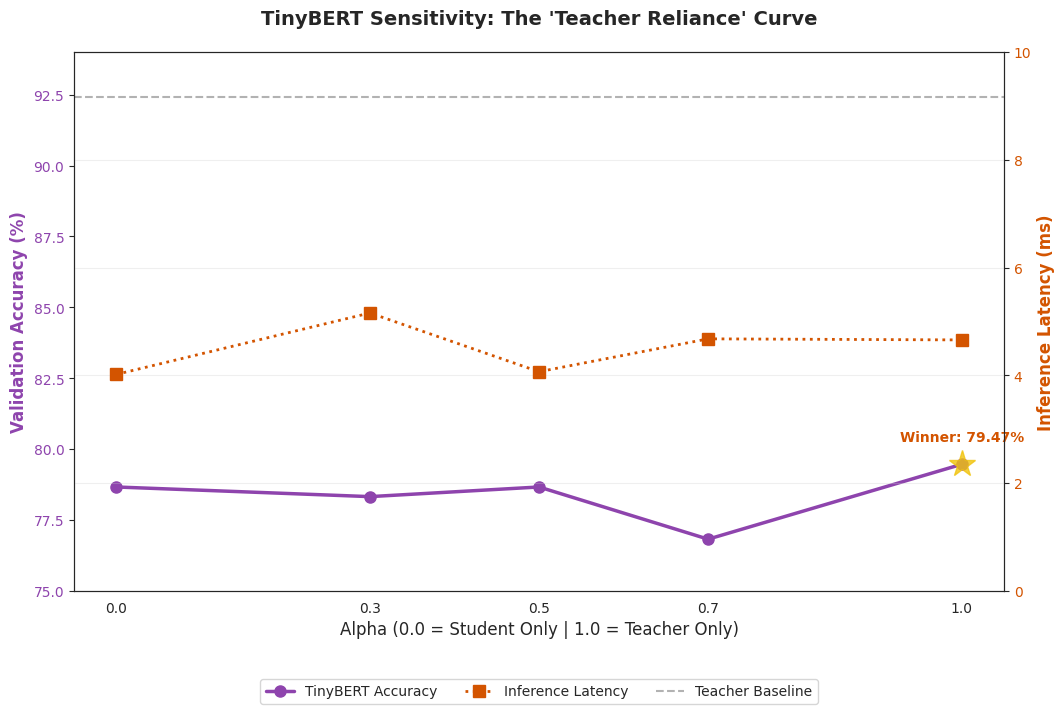

In [ ]:
# ==========================================
# STEP 4: TINYBERT SENSITIVITY ANALYSIS (VISUALIZATION)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. DATA ENTRY (From your Step 3 Logs)
# ==============================================
alphas      = [0.0, 0.3, 0.5, 0.7, 1.0]
accuracies  = [78.67, 78.33, 78.67, 76.83, 79.47]  # INT8 Accuracies
latencies   = [4.02, 5.16, 4.07, 4.68, 4.66]       # INT8 Latencies (ms)
teacher_acc = 92.43

# 2. PLOT CONFIGURATION
# ==============================================
sns.set_style("white")
fig, ax1 = plt.subplots(figsize=(12, 7))

# --- AXIS 1: ACCURACY (The Ramp) ---
color_acc = '#8e44ad' # Purple (Distinct from MiniBERT's Blue)
ax1.set_xlabel("Alpha (0.0 = Student Only | 1.0 = Teacher Only)", fontsize=12)
ax1.set_ylabel("Validation Accuracy (%)", fontsize=12, color=color_acc, weight='bold')
line1 = ax1.plot(alphas, accuracies, marker='o', linestyle='-', linewidth=2.5, markersize=8, color=color_acc, label='TinyBERT Accuracy')
ax1.tick_params(axis='y', labelcolor=color_acc)
ax1.set_ylim(75, 94) # Consistent scale with previous graphs

# Highlight the Winner (Alpha 1.0)
best_index = np.argmax(accuracies)
ax1.plot(alphas[best_index], accuracies[best_index], marker='*', markersize=20, color='#f1c40f', alpha=0.8) # Gold Star
ax1.text(alphas[best_index], accuracies[best_index] + 0.8, f"Winner: {accuracies[best_index]}%",
         ha='center', color='#d35400', weight='bold')

# Teacher Baseline
line3 = ax1.axhline(y=teacher_acc, color='gray', linestyle='--', alpha=0.6, label='Teacher Baseline')

# --- AXIS 2: LATENCY (The Check) ---
ax2 = ax1.twinx()
color_lat = '#d35400' # Pumpkin Orange
ax2.set_ylabel("Inference Latency (ms)", fontsize=12, color=color_lat, weight='bold')
line2 = ax2.plot(alphas, latencies, marker='s', linestyle=':', linewidth=2, markersize=8, color=color_lat, label='Inference Latency')
ax2.tick_params(axis='y', labelcolor=color_lat)
ax2.set_ylim(0, 10) # Zoomed in for low latency

# 3. LEGEND & TITLES
# ==============================================
lines = line1 + line2 + [line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=True)

plt.title("TinyBERT Sensitivity: The 'Teacher Reliance' Curve", fontsize=14, weight='bold', pad=20)
plt.xticks(alphas)
plt.grid(True, alpha=0.3)

filename = "Experiment_3_TinyBERT_Curve.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"✅ TinyBERT Graph saved as '{filename}'")

plt.show()

In [ ]:
# ==========================================
# BONUS STEP 1: RESOLVING THE CURVE (MULTI-SEED RE-TRAINING)
# ==========================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification

# Import your existing helper for evaluation
from project_core import evaluate_accuracy

# --- 1. CONFIGURATION ---
STUDENT_ID = "google/bert_uncased_L-2_H-128_A-2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. DEFINE THE FLEXIBLE TRAINING LOOP ---
def train_distillation_flexible(student, teacher, dataset, optimizer, device, alpha, seed):
    student.train()
    teacher.eval()

    # Create dataloader with SPECIFIC SEED
    train_loader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        generator=torch.Generator().manual_seed(seed)
    )

    temperature = 4.0

    for batch in train_loader:
        b_input = batch['input_ids'].to(device)
        b_mask = batch['attention_mask'].to(device)
        b_labels = batch['label'].to(device)

        with torch.no_grad():
            t_logits = teacher(b_input, attention_mask=b_mask).logits

        s_logits = student(b_input, attention_mask=b_mask).logits

        soft_loss = nn.KLDivLoss(reduction="batchmean")(
            F.log_softmax(s_logits / temperature, dim=1),
            F.softmax(t_logits / temperature, dim=1)
        ) * (temperature ** 2)

        hard_loss = F.cross_entropy(s_logits, b_labels)
        loss = (alpha * soft_loss) + ((1.0 - alpha) * hard_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return student

# --- 3. RUN THE EXPERIMENT ---
bonus_alphas = [0.5, 0.7, 1.0]
seeds = [42, 123, 2026]

# CRITICAL FIX: Initialize the dictionary to store the models
trained_students = {}
bonus_results = {}

# Resource Loading
try:
    train_dataset = resources['train_loader'].dataset
    teacher_model = resources['teacher']
    teacher_model.to(device)
except NameError:
    raise ValueError("⚠️ 'resources' variable is missing! Please run STEP 1 first.")

print(f"--- STARTING BONUS STEP 1 ---")
print(f"Device: {device}")

for alpha in bonus_alphas:
    accuracies = []
    print(f"\nProcessing Alpha: {alpha}...")

    for seed in seeds:
        print(f"   - Training Seed {seed}...", end="")

        # A. SET SEEDS
        torch.manual_seed(seed)
        np.random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

        # B. FRESH STUDENT & OPTIMIZER
        student_model = AutoModelForSequenceClassification.from_pretrained(STUDENT_ID, num_labels=2)
        student_model.to(device)

        optimizer = AdamW(student_model.parameters(), lr=5e-5)

        # C. TRAIN
        trained_model = train_distillation_flexible(
            student_model,
            teacher_model,
            train_dataset,
            optimizer,
            device,
            alpha=alpha,
            seed=seed
        )

        # D. SAVE MODEL TO DICTIONARY (CRITICAL STEP)
        trained_students[(alpha, seed)] = trained_model

        # E. QUICK EVAL (Inline)
        trained_model.eval()
        correct = 0
        total = 0
        val_loader = resources['val_loader']

        with torch.no_grad():
            for batch in val_loader:
                b_input = batch['input_ids'].to(device)
                b_mask = batch['attention_mask'].to(device)
                b_labels = batch['label'].to(device)

                outputs = trained_model(b_input, attention_mask=b_mask)
                preds = torch.argmax(outputs.logits, dim=-1)
                correct += (preds == b_labels).sum().item()
                total += b_labels.size(0)

        acc = (correct / total) * 100
        accuracies.append(acc)
        print(f" Done. Acc: {acc:.2f}%")

    # Average for reference
    avg_acc = sum(accuracies) / len(accuracies)
    bonus_results[alpha] = avg_acc
    print(f"   >>> Alpha {alpha} Avg: {avg_acc:.2f}%")

print("\n--- BONUS STEP 1 COMPLETE ---")
print(f"Models saved: {len(trained_students)}")

--- STARTING BONUS STEP 1 ---
Device: cuda

Processing Alpha: 0.5...
   - Training Seed 42... Done. Acc: 86.42%
   - Training Seed 123... Done. Acc: 86.26%
   - Training Seed 2026... Done. Acc: 86.13%
   >>> Alpha 0.5 Avg: 86.27%

Processing Alpha: 0.7...
   - Training Seed 42... Done. Acc: 86.40%
   - Training Seed 123... Done. Acc: 86.22%
   - Training Seed 2026... Done. Acc: 86.10%
   >>> Alpha 0.7 Avg: 86.24%

Processing Alpha: 1.0...
   - Training Seed 42... Done. Acc: 86.34%
   - Training Seed 123... Done. Acc: 86.13%
   - Training Seed 2026... Done. Acc: 86.07%
   >>> Alpha 1.0 Avg: 86.18%

--- BONUS STEP 1 COMPLETE ---
Models saved: 9


In [ ]:
# ==========================================
# BONUS STEP 2: HUNGER GAMES (9-MODEL EVALUATION)
# ==========================================
import project_core as core
import importlib
import torch
import time
import os

importlib.reload(core)

# Check if trained_students exists
if 'trained_students' not in locals() or not trained_students:
    raise ValueError("⚠️ 'trained_students' dictionary is missing. Please run BONUS STEP 1 first.")

# 1. Configuration parameters
EDGE_DEVICE_BUDGET = 1024
STRESS_FACTOR = 1
STUDENT_ID = "google/bert_uncased_L-2_H-128_A-2"

print("INITIATING HARDWARE CALIBRATION PROTOCOL")
print("-" * 115)

# 2. System Overhead Calibration
system_overhead = core.calibrate_system_overhead(
    model_name=STUDENT_ID,
    dataset_id="stanfordnlp/sst2",
    dataset_config="default"
)

total_limit = system_overhead + EDGE_DEVICE_BUDGET

print(f"System Overhead (Runtime):      {system_overhead:.2f} MB")
print(f"Edge Device Budget:             {EDGE_DEVICE_BUDGET:.2f} MB")
print(f"Total Enforced Memory Limit:    {total_limit:.2f} MB")
print("-" * 115)

print(f"\nINITIATING INFERENCE BENCHMARK (Stress Factor: {STRESS_FACTOR}x)")
print(f"Evaluating {len(trained_students)} Models...")
print(f"Memory Limit: {total_limit:.2f} MB")
print("-" * 115)
print(f"{'Model Configuration':<35} | {'Status':<10} | {'Acc (%)':<8} | {'Lat (ms)':<9} | {'Storage':<9} | {'Net Mem':<10}")
print("-" * 115)

# 3. Benchmark Execution Loop
# Sort by Alpha then Seed
sorted_keys = sorted(list(trained_students.keys()), key=lambda x: (x[0], x[1]))

for key in sorted_keys:
    student_model = trained_students[key]
    alpha, seed = key

    label = f"TinyBERT (a={alpha}, s={seed})"

    # A. Deployment Preparation (Quantization)
    student_model.to('cpu')
    quantized_student = core.quantize_student_model(student_model)

    # B. Storage Footprint Measurement
    safe_label = f"{alpha}_{seed}"
    temp_filename = f"temp_quant_{safe_label}.pt"

    torch.save(quantized_student.state_dict(), temp_filename)
    file_size_mb = os.path.getsize(temp_filename) / (1024 * 1024)

    if os.path.exists(temp_filename):
        os.remove(temp_filename)

    # C. Run Edge Simulation
    start_time = time.time()

    results = core.evaluate_on_edge(
        model=quantized_student,
        model_name=STUDENT_ID,
        dataset_id="stanfordnlp/sst2",
        dataset_config="default",
        max_memory_mb=total_limit,
        is_quantized=True,
        stress_factor=STRESS_FACTOR
    )

    elapsed_time = time.time() - start_time

    # D. Report Generation
    status = results['status']
    net_memory = max(0, results['peak_memory_mb'] - system_overhead)

    if status == "SUCCESS":
        print(f"{label:<35} | {status:<10} | {results['accuracy']:<8.2f} | {results['latency_ms']:<9.2f} | {file_size_mb:<8.2f} MB | ~{net_memory:.0f} MB")
    else:
        print(f"{label:<35} | {status:<10} | {'N/A':<8} | {'N/A':<9} | {file_size_mb:<8.2f} MB | {results['peak_memory_mb']:.2f} MB")

print("-" * 115)
print("SIMULATION PROTOCOL COMPLETE.")

INITIATING HARDWARE CALIBRATION PROTOCOL
-------------------------------------------------------------------------------------------------------------------
System Overhead (Runtime):      757.58 MB
Edge Device Budget:             1024.00 MB
Total Enforced Memory Limit:    1781.58 MB
-------------------------------------------------------------------------------------------------------------------

INITIATING INFERENCE BENCHMARK (Stress Factor: 1x)
Evaluating 9 Models...
Memory Limit: 1781.58 MB
-------------------------------------------------------------------------------------------------------------------
Model Configuration                 | Status     | Acc (%)  | Lat (ms)  | Storage   | Net Mem   
-------------------------------------------------------------------------------------------------------------------
TinyBERT (a=0.5, s=42)              | SUCCESS    | 80.96    | 3.91      | 15.59    MB | ~726 MB
TinyBERT (a=0.5, s=123)             | SUCCESS    | 80.62    | 4.50      | 